# 6.819 / 6.869 Miniplaces Part 2

Welcome to the Miniplaces Challenge, Part 2!

The goal of this challenge is to build a scene classifier that classifies a 128x128 image into one of several categories, such as art gallery, amusement park, or airport terminal.
The Miniplaces dataset is a more managable subset of the larger "Places" dataset, with images from 100 categories.

During the challenge, you will try and get the best top-5 accuracy on the test set, whose labels are hidden. You will submit your inferred labels for each of the test set images to a web server for grading.

## Logistics
Read carefully!

The Miniplaces Challenge is released on Mon 4/12. \
**Submissions are due by Wednesday 04/21 at 11:59PM** 

**This Challenge will take a lot of time, because each network can take hours to days to train. Please start early!**

You may work in teams of up to 2. Each team member will need to submit individual reports, but may use the same code / results.

To train neural networks from scratch, you will need a GPU. We encourage you to use AWS servers or Google Colab, if you do not have access to a GPU locally. We provide $150 of AWS credits that you can use on the Miniplaces Challenge, and you can use the remainder for your final project. We don't expect Miniplaces will use all of this credit. If you need more credits (particularly for final projects), post a Private question on Piazza addressed to all Staff. Please stop your AWS instance when you're done using it, to avoid accidentally consuming credits.

Additionally, during this challenge, you will use your model to label a test set. We will be hosting a web server that evaluates your labelling. Your model should guess 5 categories for each test image. If any one of these is correct, we will say your model has classified the image correctly. This metric is called the "Top-5" Error.

## Writeup and Grading

### **Problem 1** (5 points)

We want you to get a feel for the impact of specific design choices on the performance of the network. Experiment with some of the following hyperparameters / techniques:

*   Data augmentation
*   Weight initialization
*   Residual connections (ResNet) and dense connections (DenseNet), compared to networks without them (VGGNet, AlexNet)
*   Number of layers, or number of layer features
*   Type of optimizer
*   Learning rate and/or schedule

**6.819**: Choose at least 2 techniques

**6.869**: Choose at least 3 techniques

For each technique you choose, plot the top-5 error of your modified network against the top-5 error of the original network for both the training and validation sets. Try with several different
hyperparameter values! For example, if you choose to modify the learning rate, plot a chart of learning rate vs. top-5 error. **Briefly describe the techniques you tried, and suggest a brief explanation for your results.**

### **Problem 2** (5 points)

Putting together what you learned from Problem 1 (as well as other techniques if you wish), build the best classifier you can.

**You MAY NOT use pretrained weights, or other datasets, to train your network.** *Although in real applications, you may want to start by finetuning a network pretrained on ImageNet, here we want you to focus on the design of the network architecture and training scheme. The impact of your design choices will be more apparent without pretraining.*

This problem will be graded based on your model's top-5 accuracy on the test set:

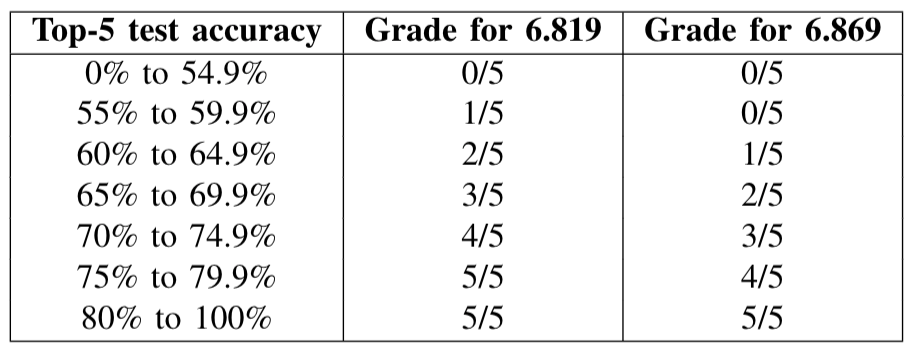

In addition, you will earn one bonus mark (i.e. a grade of 6/5) if you are top 20 on the leaderboard (as of 4/21 at 11:59PM), and two bonus marks (7/5) if you are top 5 on the leaderboard. A single leaderboard will be used for both 6.819 and 6.869. 

In your report, please write down your test top-5 accuracy and a **very brief** summary of the design choices you made, e.g. "65.2% accuracy. ResNet-18, data augmentation by rotation, SGD optimizer, learning rate of 0.5, 10% dropout". You do not need to write anything else. 

You should submit a zip file with a PDF report and your code on stellar whose filename is prefixed by your kerberos ex: `yourkerberos.zip`. We only care that your kerberos is clearly visible - if it helps you organize, you may add more to the filename, seperated by underscore (`yourkerberos_miniplaces2.zip`). Make sure to submit the correct zip file! Please do NOT submit the dataset in your submission! (It's huge!)

**Late Submission Policy:** You may submit this assignment up to 1 week late, with partial credit that linearly decreases to 1/2 credit, as indicated by our late policy on the course website. However, extra credit will only be given to the top 20 teams on the leaderboard as of the original deadline.

# Submission Server
The file `miniplaces_grader.py` contains the client code necessary to submit test set evaluations, form a team, and get AWS credits. Please use the `-h` flag of that script for usage. Run that locally! 


In [2]:
my_name = "Nada Hussein"
my_teammate = "" # Fill in if you have a teammate, leave blank otherwise
my_team_name = "nada" # Your team name on the submission server

print("I'm %s. I worked with %s. I'm on team %s" % (my_name, my_teammate, my_team_name))

I'm Nada Hussein. I worked with . I'm on team nada


# Section 1: Downloading the dataset

You can download the dataset from <http://6.869.csail.mit.edu/fa19/miniplaces_part2/data.zip>

Unzip this to some directory. Our data folder follows the format of the `ImageFolder` class <https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder>

In [3]:
import os

data_dir = "./data"

if not os.path.exists(data_dir):
  !wget http://6.869.csail.mit.edu/fa19/miniplaces_part2/data.zip
  !unzip data.zip

data_dir = "./data"

Streaming output truncated to the last 5000 lines.
  inflating: data/val/gas_station/00004741.jpg  
  inflating: data/val/gas_station/00004880.jpg  
  inflating: data/val/gas_station/00005437.jpg  
  inflating: data/val/gas_station/00005469.jpg  
  inflating: data/val/gas_station/00005593.jpg  
  inflating: data/val/gas_station/00005624.jpg  
  inflating: data/val/gas_station/00005684.jpg  
  inflating: data/val/gas_station/00005688.jpg  
  inflating: data/val/gas_station/00005828.jpg  
  inflating: data/val/gas_station/00006273.jpg  
  inflating: data/val/gas_station/00006440.jpg  
  inflating: data/val/gas_station/00006483.jpg  
  inflating: data/val/gas_station/00006694.jpg  
  inflating: data/val/gas_station/00006715.jpg  
  inflating: data/val/gas_station/00006752.jpg  
  inflating: data/val/gas_station/00006777.jpg  
  inflating: data/val/gas_station/00006862.jpg  
  inflating: data/val/gas_station/00007026.jpg  
  inflating: data/val/gas_station/00007275.jpg  
  inflating: data/

# Section 2: Training a Model

Now, we'll train a model. This code was adapted from <https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html>

You are free to delete this code entirely and start from scratch, or modify it in whatever way you choose

## Dependencies

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
# You might not have tqdm, which gives you nice progress bars
!pip install tqdm
from tqdm.notebook import tqdm
import os
import copy

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only")

Using the GPU!


## Initialize an Empty Model

First, we need to initialize an empty model, that will input an image, and output a classification. Each model is a little different, so we'll make a helper function that takes in an architecture name, and outputs a model. This is only meant as a guideline, and you can try using different models! `torchvision.models` has other common architectures, and variations on these (like ResNet-50 and ResNet-101), so you may want to try those out.

We also add a `resume_from` argument to specify model weights to load, In case you save a model and want to use it again.

In [5]:
def initialize_model(model_name, num_classes, resume_from = None):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    # The model (nn.Module) to return
    model_ft = None
    # The input image is expected to be (input_size, input_size)
    input_size = 0
    
    # You may NOT use pretrained models!! 
    use_pretrained = False
    
    # By default, all parameters will be trained (useful when you're starting from scratch)
    # Within this function you can set .requires_grad = False for various parameters, if you
    # don't want to learn them

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    else:
        raise Exception("Invalid model name!")
    
    if resume_from is not None:
        print("Loading weights from %s" % resume_from)
        model_ft.load_state_dict(torch.load(resume_from))
    
    return model_ft, input_size

## Data Loading

With the input size from the model, we can now load the dataset

In [6]:
def get_dataloaders(input_size, batch_size, shuffle = True):
    # How to transform the image when you are loading them.
    # you'll likely want to mess with the transforms on the training set.
    
    # For now, we resize/crop the image to the correct input size for our network,
    # then convert it to a [C,H,W] tensor, then normalize it to values with a given mean/stdev. These normalization constants
    # are derived from aggregating lots of data and happen to produce better results.
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }
    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in data_transforms.keys()}
    # Create training and validation dataloaders
    # Never shuffle the test set
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False if x != 'train' else shuffle, num_workers=4) for x in data_transforms.keys()}
    return dataloaders_dict

## Training
Next, let's make a helper function that trains the given model

In [7]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, save_all_epochs=False, num_epochs=25):
    '''
    model: The NN to train
    dataloaders: A dictionary containing at least the keys 
                 'train','val' that maps to Pytorch data loaders for the dataset
    criterion: The Loss function
    optimizer: The algorithm to update weights 
               (Variations on gradient descent)
    num_epochs: How many epochs to train for
    save_dir: Where to save the best model weights that are found, 
              as they are found. Will save to save_dir/weights_best.pt
              Using None will not write anything to disk
    save_all_epochs: Whether to save weights for ALL epochs, not just the best
                     validation error epoch. Will save to save_dir/weights_e{#}.pt
    '''
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # torch.max outputs the maximum value, and its index
                    # Since the input is batched, we take the max along axis 1
                    # (the meaningful outputs)
                    _, preds = torch.max(outputs, 1)

                    # backprop + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if save_all_epochs:
                torch.save(model.state_dict(), os.path.join(save_dir, f'weights_{epoch}.pt'))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # save and load best model weights
    torch.save(best_model_wts, os.path.join(save_dir, 'weights_best.pt'))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## Optimizer & Loss
We need a loss function, and an optimization function to use to try to reduce that loss.

In [8]:
def make_optimizer(model, opt, lr):
    # Get all the parameters
    params_to_update = model.parameters()
    print("Params to learn:")
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    if opt == "sgd":
        optimizer = optim.SGD(params_to_update, lr=lr, momentum=0.9)
    elif opt == "adam":
      optimizer = optim.Adam(params_to_update, lr=lr)
    elif opt == "adagrad":
      optimizer = optim.Adagrad(params_to_update, lr=lr)
    elif opt == "adadelta":
      optimizer = optim.Adadelta(params_to_update, lr=lr)
    else:
        raise Exception('Invalid optimizer.')
    return optimizer

def get_loss():
    # Create an instance of the loss function
    criterion = nn.CrossEntropyLoss()
    return criterion

## Inputs

Here, we set up some of the various parameters that we can change to run the code. You can add change the values given here, or add new ones! This is just a template.

Our data is conveniently set up to follow the expected format of the  `ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset class, rather than writing our own custom dataset.

The ``model_name`` input is the name of the model you wish to use. We've provided starter code that initializes these models using provided models in TorchVision (a PyTorch library)

The code as is supports the following values: [resnet, alexnet, vgg, squeezenet, densenet]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, 100 here, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs (passes through the dataset) we want to run.




In [9]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
# You can add your own, or modify these however you wish!
model_name = "densenet"

# Number of classes in the dataset
# Miniplaces has 100
num_classes = 100

# Batch size for training (change depending on how much memory you have)
# You should use a power of 2.
batch_size = 16

# Shuffle the input data?
shuffle_datasets = True

# Number of epochs to train for 
num_epochs = 15

### IO
# Path to a model file to use to start weights at
resume_from = None

# Directory to save weights to
save_dir = "weights"
os.makedirs(save_dir, exist_ok=True)

# Save weights for all epochs, not just the best one
save_all_epochs = False



## Tying it all together - Training

In [ ]:
model, input_size = initialize_model(model_name = model_name, num_classes = num_classes, resume_from = resume_from)
dataloaders = get_dataloaders(input_size, batch_size, shuffle_datasets)
criterion = get_loss()

# Move the model to the gpu if needed
model = model.to(device)

optimizer = make_optimizer(model, "adam", 0.001)

# Train the model!
trained_model, validation_history = train_model(model=model, dataloaders=dataloaders, criterion=criterion, optimizer=optimizer,
           save_dir=save_dir, save_all_epochs=save_all_epochs, num_epochs=num_epochs)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

# Section 3: Inference

Now that we've trained a model, we would like to evaluate its performance (on the validation data), and use it for inference (on the test data). We're going to perform top-5 inference - that is, our model will get to output 5 guesses for a given image


In [ ]:
def evaluate(model, dataloader, criterion, is_labelled = False, generate_labels = True, k = 5):
    # If is_labelled, we want to compute loss, top-1 accuracy and top-5 accuracy
    # If generate_labels, we want to output the actual labels
    # Set the model to evaluate mode
    model.eval()
    running_loss = 0
    running_top1_correct = 0
    running_top5_correct = 0
    predicted_labels = []
    

    # Iterate over data.
    # TQDM has nice progress bars
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        tiled_labels = torch.stack([labels.data for i in range(k)], dim=1) 
        # Makes this to calculate "top 5 prediction is correct"
        # [[label1 label1 label1 label1 label1], [label2 label2 label2 label label2]]

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            # Get model outputs and calculate loss
            outputs = model(inputs)
            if is_labelled:
                loss = criterion(outputs, labels)

            # torch.topk outputs the maximum values, and their indices
            # Since the input is batched, we take the max along axis 1
            # (the meaningful outputs)
            _, preds = torch.topk(outputs, k=5, dim=1)
            if generate_labels:
                # We want to store these results
                nparr = preds.cpu().detach().numpy()
                predicted_labels.extend([list(nparr[i]) for i in range(len(nparr))])

        if is_labelled:
            # statistics
            running_loss += loss.item() * inputs.size(0)
            # Check only the first prediction
            running_top1_correct += torch.sum(preds[:, 0] == labels.data)
            # Check all 5 predictions
            running_top5_correct += torch.sum(preds == tiled_labels)
        else:
            pass

    # Only compute loss & accuracy if we have the labels
    if is_labelled:
        epoch_loss = float(running_loss / len(dataloader.dataset))
        epoch_top1_acc = float(running_top1_correct.double() / len(dataloader.dataset))
        epoch_top5_acc = float(running_top5_correct.double() / len(dataloader.dataset))
    else:
        epoch_loss = None
        epoch_top1_acc = None
        epoch_top5_acc = None
    
    # Return everything
    return epoch_loss, epoch_top1_acc, epoch_top5_acc, predicted_labels

    

In [ ]:
# Get data on the validation set
# Setting this to false will be a little bit faster
generate_validation_labels = True
val_loss, val_top1, val_top5, val_labels = evaluate(model, dataloaders['val'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 5)
print(val_loss, val_top1, val_top5, val_labels)

train_loss, train_top1, train_top5, train_labels = evaluate(model, dataloaders['train'], criterion, is_labelled = True, generate_labels = generate_validation_labels, k = 5)
print(train_loss, train_top1, train_top5, train_labels)
# Get predictions for the test set
_, _, _, test_labels = evaluate(model, dataloaders['test'], criterion, is_labelled = False, generate_labels = True, k = 5)


# Submission Prep & Human-Readable Inference

Now that we have predicted labels for our data, let's convert the predictions into a nice JSON that we can submit to the web server!

Note that this will only work if you are NOT shuffling your dataset!

In [ ]:
''' These convert your dataset labels into nice human readable names '''

import json

def label_number_to_name(lbl_ix):
    return dataloaders['val'].dataset.classes[lbl_ix]

def dataset_labels_to_names(dataset_labels, dataset_name):
    # dataset_name is one of 'train','test','val'
    dataset_root = os.path.join(data_dir, dataset_name)
    found_files = []
    for parentdir, subdirs, subfns in os.walk(dataset_root):
        parentdir_nice = os.path.relpath(parentdir, dataset_root)
        found_files.extend([os.path.join(parentdir_nice, fn) for fn in subfns if fn.endswith('.jpg')])
    # Sort alphabetically, this is the order that our dataset will be in
    found_files.sort()
    # Now we have two parallel arrays, one with names, and the other with predictions
    assert len(found_files) == len(dataset_labels), "Found more files than we have labels"
    preds = {os.path.basename(found_files[i]):list(map(label_number_to_name, dataset_labels[i])) for i in range(len(found_files))}
    return preds
    

test_labels_js = dataset_labels_to_names(test_labels, "test")

output_test_labels = "test_set_predictions"
output_salt_number = 7

output_label_dir = "."

while os.path.exists(os.path.join(output_label_dir, '%s%d.json' % (output_test_labels, output_salt_number))):
    output_salt_number += 1
    # Find a filename that doesn't exist
    

with open(os.path.join(output_label_dir, '%s%d.json' % (output_test_labels, output_salt_number)), "w") as f:
    json.dump(test_labels_js, f, sort_keys=True, indent=4)
    
print("Wrote predictions to:\n%s" % os.path.abspath(os.path.join(output_label_dir, '%s%d.json' % (output_test_labels, output_salt_number))))


# Web Server Submission

Now that you have a prediction JSON file, you should submit it via webserver using the `miniplaces_grader.py` script!

Use `-h` for up-to-date help on the script. You can use it to create your miniplaces team, request AWS credits, view the leaderboards, and view the test set scores for your submission.

If your score is "Pending" - don't worry! We only allow 1 submission per 2 hours, and will release results each time this timer resets. This is to prevent you from overfitting to the test set - you can overfit to the training set easily (since you train on it). You can overfit to the validation set, since you choose your hyperparameters based on that. You can ALSO overfit to the test set, by choosing your model based on your test set performance. So, to prevent you from using the test set too many times (at which point it would become part of your training), we restrict how often you can test.